# Spectrum Processing with Artificial Newral Networks

## Generating semi-syntetic spectrums

In [1]:
# Directories with short-time spectrums of background and Cs-137 dot source
bkg_dir = '/home/alex/mybox/IRB/BRFFI_spectrometry/Spectr_BRFFI_ns/2020_05_29_bkg_1sec/'
sgn_dir = '/home/alex/mybox/IRB/BRFFI_spectrometry/Spectr_BRFFI_ns/2020_05_29_cs137_2cm_10kbq_1sec/'

In [2]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime

def read_spectrs(directory, tp='spe'):
  '''
   Считывает файлы спектров (канал, время-дата, температура и т.п.) 
   в формате spe
   с расширением tp из заданной папки directory
   и помещает их в dataframe
   Procedure for reading files from folder
   retrieving data on counts in channels, date-time, temperature etc.
  '''
  detector = []
  det_num = []
  cps = []
  temp = []
  date_time = []
  mestime = []
  dose = []
  energ_cal = []
  for fl in os.listdir(directory):
    if tp in fl:
      with open(directory+fl, 'r', encoding='cp1251') as spectr:
        flag = ''
        chanl = -1
        for line in spectr:
          if 'COM' in line:
            tdat = line.split(' ')
            detector.append(tdat[1])
            det_num.append(tdat[2][3:-1])
          if flag == 'data' and chanl >= 0:
            spec[chanl] = int(line.strip())
            chanl += 1
            if chanl > nchanl :
              flag = ''
              chanl = -1
              try :
                spectrums
              except NameError :
                spectrums = spec.reshape(1, -1)
              else :
                spectrums = np.vstack((spectrums, spec.reshape(1, -1)))
          if flag == 'data' and chanl == -1:
            chanl = 0
            nchanl = int(line.split(' ')[1])
            spec = np.zeros(nchanl+1)
          if '$DATA' in line:
            flag = 'data'
          if flag == 'enrg':
            energ = line.split(' ')
            energ[0] = float(energ[0])
            energ[1] = float(energ[1])
            energ_cal.append(energ)
            flag = ''
          if '$ENER_FIT' in line:
            flag = 'enrg'
          if flag == 'date':
            dat_time = line.split(' ')
            dat = dat_time[0].split('/')
            time = dat_time[1].split(':')
            dat_time = datetime(int(dat[2]), int(dat[0]), int(dat[1]), int(time[0]), int(time[1]), int(time[2]))
            date_time.append(dat_time)
            flag = ''
          if '$DATE_MEA' in line:
            flag = 'date'
          if flag == 'dose':
            dose.append(float(line))
            flag = ''
          if '$DOSE_RATE' in line:
            flag = 'dose'          
          if flag == 'mestm':
            mes_time = line.split(' ')
            mestime.append([int(mes_time[0]), int(mes_time[1])])
            flag = ''
          if '$MEAS_TIM' in line:
            flag = 'mestm'
          if flag == 'cps':
            cps.append(float(line))
            flag = ''
          if '$CPS' in line:
            flag = 'cps'
          if flag == 'temp':
            temp.append(float(line))
            flag = ''
          if '$TEMPERATURE' in line:
            flag = 'temp'  
  chanls = []
  for i in range(1,spectrums.shape[1]+1):
    chanls.append('ch_'+str(i))
  heads = chanls[:]
  spectrums = np.hstack((spectrums, np.array(cps).reshape(-1, 1)))
  spectrums = np.hstack((spectrums, np.array(mestime).reshape(-1, 2)))
  spectrums = np.hstack((spectrums, np.array(date_time).reshape(-1, 1)))
  spectrums = np.hstack((spectrums, np.array(temp).reshape(-1, 1)))
  spectrums = np.hstack((spectrums, np.array(detector).reshape(-1, 1)))
  spectrums = np.hstack((spectrums, np.array(det_num).reshape(-1, 1)))
  spectrums = np.hstack((spectrums, np.array(dose).reshape(-1, 1)))
  spectrums = np.hstack((spectrums, np.array(energ_cal).reshape(-1, 2)))

  heads.append('cps')
  heads.append('live_mes_time')
  heads.append('total_mes_time')
  heads.append('date_time')
  heads.append('temperature')
  heads.append('detector_type')
  heads.append('detector_num')
  heads.append('dose_rate') # nSv/h
  heads.append('energ_cal_0')
  heads.append('energ_cal_1')
  data = pd.DataFrame(data=spectrums, columns=heads)
  data[chanls] = data[chanls].astype('int')
  data[['live_mes_time', 'total_mes_time']] = data[['live_mes_time', 'total_mes_time']].astype('int')
  data[['cps', 'temperature', 'dose_rate', 'energ_cal_0', 'energ_cal_1']] = data[['cps', 'temperature', 'dose_rate', 'energ_cal_0', 'energ_cal_1']].astype('float')
  data['date_time'] = pd.to_datetime(data['date_time'])
  return data

In [3]:
# loading spectrums into DataFrames
bkg_data = read_spectrs(directory=bkg_dir)
sgn_data = read_spectrs(directory=sgn_dir)
chnls = [nm for nm in bkg_data.columns if 'ch_' in nm]

(bkg_data.shape, sgn_data.shape)

((17489, 522), (14575, 522))

In [4]:
# Generating train and validate sets of spectrum
import random

n_sample_train = 10000 # number of spectrum in train set
n_sample_validate = 1000
live_time = 100 # live time of semysintetic spectrum
source_activity = 10000.0 # activity of dot soirce, Bq

def generate_sample(sgn_data, bkg_data, cols):
  n_signal = random.randrange(live_time+1)
  activity = source_activity * n_signal / live_time
  bkg = bkg_data[cols].sample(live_time - n_signal, replace=True).to_numpy() # live_time - n_signal
  sgn = sgn_data[cols].sample(n_signal, replace=True).to_numpy()
  spec = np.append(bkg, sgn, axis=0).mean(axis=0)
  return spec, activity

x_train = np.array([])
y_train = np.array([])
for i in range(n_sample_train):
  smpl = generate_sample(sgn_data, bkg_data, chnls)
  if x_train.size > 0:
    x_train = np.append(x_train, smpl[0].reshape(1, -1), axis=0)
    y_train = np.append(y_train, np.array(smpl[1]).reshape(1, 1), axis=0)
  else:
    x_train = smpl[0].reshape(1, -1)
    y_train = np.array(smpl[1]).reshape(1, 1)

x_val = np.array([])
y_val = np.array([])
for i in range(n_sample_validate):
  smpl = generate_sample(sgn_data, bkg_data, chnls)
  if x_val.size > 0:
    x_val = np.append(x_val, smpl[0].reshape(1, -1), axis=0)
    y_val = np.append(y_val, np.array(smpl[1]).reshape(1, 1), axis=0)
  else:
    x_val = smpl[0].reshape(1, -1)
    y_val = np.array(smpl[1]).reshape(1, 1)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((10000, 512), (10000, 1), (1000, 512), (1000, 1))

In [5]:
from matplotlib import pyplot as plt

minispec = x_train[np.argmin(y_train[y_train > 0]), :]
maxispec = x_train[np.argmax(y_train[y_train < 9500]), :]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
axes[0].plot(minispec)
axes[1].plot(maxispec)
axes[1].set_xlabel('channel')
axes[0].set_ylabel('count rate, $s^{-1}$')
axes[1].set_ylabel('count rate, $s^{-1}$')
axes[0].set_title(f'Activity {np.min(y_train[y_train > 0])} Bq')
axes[1].set_title(f'Activity {np.max(y_train[y_train < 9500])} Bq')
#fig.tight_layout()
fig.suptitle('Samples of semi-sentetic spectrums with low and high activity of $^{137}Cs$')
plt.show()

<Figure size 1000x800 with 2 Axes>

## Traditional method of spectrum processing

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


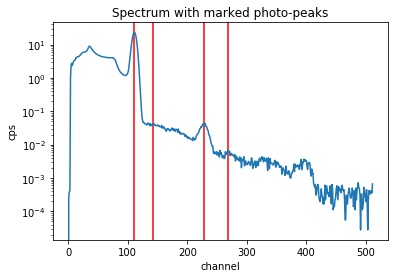

In [6]:
import seaborn as sns

# Calibration of the detector for traditional method of activity measuring
standard_activity = 10000 # Bq
spec = sgn_data[chnls].sample(36000, replace=True).to_numpy().mean(axis=0)

# energy calibration
# method of finding photo-peaks by cite:shi-2018-step-approx 
def find_peaks(spec):
  # moving average of spectrum
  spec = np.convolve(spec, np.ones(5)/5, 'same')
  derivat = np.zeros(len(spec))
  for i in range(2, len(spec)-2):
    derivat[i] = (spec[i+2] - 8*spec[i-1] + 8*spec[i+1] - spec[i-2])
  left = 0
  center = 0
  right = 0
  piks = []
  for i in range(2, len(spec)-2):   #(80, 150):
    if left == 0 and derivat[i-1] < 0 and derivat[i+1] > 0:
      left = i
      continue
    elif left > 0 and center == 0 and derivat[i-1] > 0 and derivat[i+1] < 0:
      center = i
      continue
    elif left > 0 and center > 0 and right == 0 and derivat[i-1] < 0 and derivat[i+1] > 0:
      right = i
      bkg_level = (spec[left-1:left+2].sum() + spec[right-1:right+2].sum())/6
      piks.append({'left': left, 'right': right, 'center': center, 'width': right - left - 1, 'total_area': spec[left+1:right].sum(), 'background_area': bkg_level * (right - left - 1)})
      left = 0
      right = 0
      center = 0
      continue
  return piks

piks = find_peaks(spec)
plot = sns.lineplot(data=spec)
plt.yscale('log')
plt.ylim(bottom=0)
for pik in piks:
  if pik['width'] > 20:
    plt.axvline(pik['center'], color='red', zorder=1)
    #plt.axvline(pik['left'], color='y', zorder=1)
    #plt.axvline(pik['right'], color='g', zorder=1)
plt.title('Spectrum with marked photo-peaks')
plt.ylabel('cps')
plt.xlabel('channel')

# find photopeak of Cs-137 near the channel 100
for pik in piks:
  if pik['left'] < 100 and pik['right'] > 100:
    cs137_pik = pik
    break
    
# effectiveness calibration
cs137_pik['photopeak_area'] = cs137_pik['total_area'] - cs137_pik['background_area']
cs137_pik['effectivnes'] = standard_activity / cs137_pik['photopeak_area']
# cs137_pik['effectivnes']

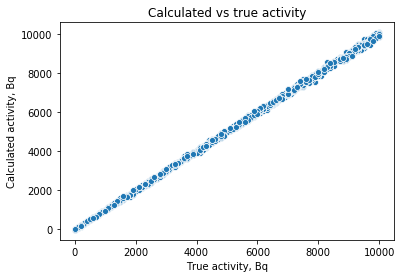

In [7]:
from sklearn.metrics import mean_squared_error

measurements = []

def spectrum_traditional_process(spec, left, right, effectivnes):
  '''
   Procedure for calculation activity by the traditional method
   spec - spectrum
   left and right - boundaries of phopeak
   effectivness - ratio of activity to cps
  '''
  bkgnd = ((spec[left-1:left+2].sum() + spec[right-1:right+2].sum())/6) * (right - left - 1)
  total = spec[left+1:right].sum()
  photopeak = total - bkgnd
  mes_activity = photopeak * effectivnes
  return mes_activity

for spec, act in zip(x_val, y_val):
  measurements.append(spectrum_traditional_process(spec, 
                                                   cs137_pik['left'], 
                                                   cs137_pik['right'], 
                                                   cs137_pik['effectivnes']))
measurements = np.array(measurements)

sns.scatterplot(x=y_val.flatten(), y=measurements)
plt.xlabel('True activity, Bq')
plt.ylabel('Calculated activity, Bq')
plt.title('Calculated vs true activity')
plt.show()

In [8]:
mset = mean_squared_error(y_true=y_val, y_pred=measurements).round(1)
print(f'Accuracy of the traditional method is {mset}')

Accuracy of the traditional method is 4850.8


## Simple regression neural network

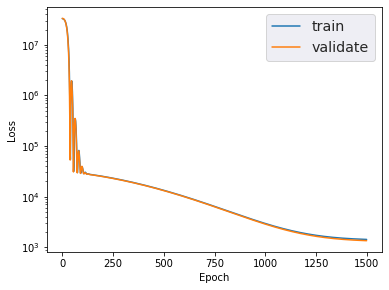

In [9]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F

input_size = len(x_train[0]) # number of channels
n_hidden_1 = 100 # size of hiddel layers
n_hidden_2 = 10

class simple_spectrum_nn_processing(torch.nn.Module):
  def __init__(self, input_size, n_hidden_1, n_hidden_2, n_output=1):
    super(simple_spectrum_nn_processing, self).__init__()
    self.hidden_1 = torch.nn.Linear(input_size, n_hidden_1)
    self.hidden_2 = torch.nn.Linear(n_hidden_1, n_hidden_2)
    self.predict = torch.nn.Linear(n_hidden_2, n_output)

  def forward(self, x):
    hid1 = F.relu(self.hidden_1(x))
    hid2 = F.relu(self.hidden_2(hid1))
    out = self.predict(hid2)
    return out

learning_rate = 0.01
n_epoch = 1500
model = simple_spectrum_nn_processing(input_size, n_hidden_1, n_hidden_2, 1)
if torch.cuda.is_available():
  model.cuda()

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
losses_val = []
for epoch in range(n_epoch):
  if torch.cuda.is_available():
    inputs = Variable(torch.from_numpy(x_train).cuda())
    labels = Variable(torch.from_numpy(y_train).cuda())
  else:
    inputs = Variable(torch.from_numpy(x_train))
    labels = Variable(torch.from_numpy(y_train))
  optimizer.zero_grad()
  outputs = model(inputs.float())
  loss = loss_function(outputs, labels.float())
  loss.backward()
  optimizer.step()
  losses.append(loss.item())
  with torch.no_grad():
    if torch.cuda.is_available():
      predict = model(Variable(torch.from_numpy(x_val).cuda().float()))
      pred_lab = Variable(torch.from_numpy(y_val).cuda().float())
    else: 
      predict = model(Variable(torch.from_numpy(x_val).float()))
      pred_lab = Variable(torch.from_numpy(y_val).float())
    loss2 = loss_function(predict, pred_lab)
    losses_val.append(loss2)
    #print(f'epoch {epoch}, loss train - {loss.item()}, loss validate - {loss2.item()}')

fig, ax = plt.subplots(figsize=(6, 4.5))
sns.set(font_scale=1.3)
sns.lineplot(data=np.array(losses), label='train')
sns.lineplot(data=np.array(losses_val), label='validate')
ax.set(yscale='log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#sns.lineplot(data=np.array(losses_val))
#loss

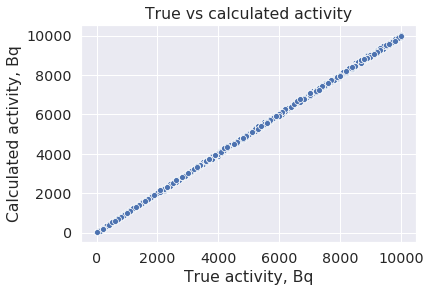

In [10]:

with torch.no_grad():
  if torch.cuda.is_available():
    predict = model(Variable(torch.from_numpy(x_val).cuda().float()))
  else: 
    predict = model(Variable(torch.from_numpy(x_val).float()))
sns.scatterplot(x=y_val.flatten(), y=predict.flatten())
plt.ylabel('Calculated activity, Bq')
plt.xlabel('True activity, Bq')
plt.title('True vs calculated activity')
plt.show()

In [11]:
msel = mean_squared_error(y_true=y_val, y_pred=predict).round(1)
print(f'Accuracy of the simple regression neural network is {msel}')

Accuracy of the simple regression neural network is 1346.6


Accuracy of the simple newral network is around 4 times better than traditional method.

## Simple 1D convolution neural network

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN3(nn.Module):
  def __init__(self):
    super(CNN3, self).__init__()
    # 1 input channel, 12 output channels, 9 linear convolution kernel
    self.conv1 = nn.Conv1d(1, 3, 9)
    self.conv2 = nn.Conv1d(3, 6, 9)
    self.conv3 = nn.Conv1d(6, 12, 9)
    self.fc1 = nn.Linear(684, 100)
    self.fc2 = nn.Linear(100, 25)
    self.fc3 = nn.Linear(25, 1)

  def forward(self, x):
    # Max pooling over a (2) window
    x = F.max_pool1d(F.relu(self.conv1(x)), 2)
    x = F.max_pool1d(F.relu(self.conv2(x)), 2)
    x = F.max_pool1d(F.relu(self.conv3(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

In [13]:
cn_net = CNN3()
cn_net = cn_net.float()

params = list(cn_net.parameters())

learning_rate = 0.01
n_epoch = 1500 #00
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(cn_net.parameters(), lr=learning_rate)
losses = []
losses_val = []

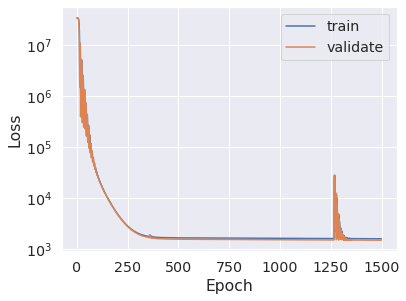

In [14]:
for epoch in range(n_epoch):
  inputs = Variable(torch.from_numpy(x_train.reshape(-1, 1, 512)))
  labels = Variable(torch.from_numpy(y_train))
  optimizer.zero_grad()
  out = cn_net(inputs.float())
  loss = loss_function(out, labels.float())
  loss.backward()
  optimizer.step()
  losses.append(loss.item())

  with torch.no_grad():
    predict = cn_net(Variable(torch.from_numpy(x_val.reshape(-1, 1, 512)).float()))
    pred_lab = Variable(torch.from_numpy(y_val).float())
    loss2 = loss_function(predict, pred_lab)
    losses_val.append(loss2)
    #print(f'epoch {epoch}, loss train - {loss.item()}, loss validate - {loss2.item()}')

fig, ax = plt.subplots(figsize=(6, 4.5))
sns.set(font_scale=1.3)
sns.lineplot(data=np.array(losses), label='train')
sns.lineplot(data=np.array(losses_val), label='validate')
ax.set(yscale='log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

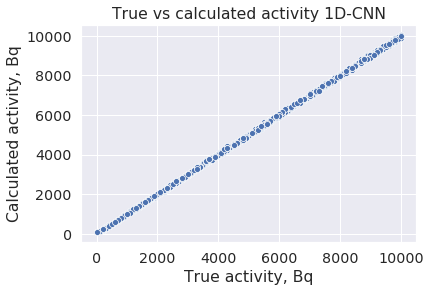

In [15]:
with torch.no_grad():
  predict = cn_net(Variable(torch.from_numpy(x_val.reshape(-1, 1, 512)).float()))
sns.scatterplot(x=y_val.flatten(), y=predict.flatten())
plt.ylabel('Calculated activity, Bq')
plt.xlabel('True activity, Bq')
plt.title('True vs calculated activity 1D-CNN')
plt.show()

In [16]:
msec = mean_squared_error(y_true=y_val, y_pred=predict).round(1)
print(f'Accuracy of the 1D convolutional neural network is {msec}')

Accuracy of the 1D convolutional neural network is 1482.3


The accuracy of 1D simple convolutional neural network is about same as fully connected regression neural network. They are substantially better than tradition method of gamma-spectrum processing.